### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
import os

### Importing Dataset

In [2]:
df = pd.read_csv("../dataset/clean_data_video_games.csv")

### Feature Selection

In [3]:
# Kita ingin memprediksi Sales berdasarkan: Platform, Genre, dan Score
# User_Score kita abaikan dulu karena korelasinya rendah di analisis sebelumnya.
cols_model = ['Platform', 'Genre', 'Critic_Score', 'Global_Sales']
df_model = df[cols_model].copy()

### One Hot Encoding (Platform & Genre)

In [4]:
# Regresi butuh input angka semua. Platform & Genre harus diubah jadi angka (0/1).
print("Melakukan Encoding...")
df_encoded = pd.get_dummies(df_model, drop_first=True) # drop_first untuk hindari multicollinearity

Melakukan Encoding...


In [5]:
# Pisahkan X (Fitur) dan y (Target)
X = df_encoded.drop(columns=['Global_Sales'])
y = df_encoded['Global_Sales']

In [8]:
# Simpan nama-nama kolom fitur (penting untuk Backend nanti)
feature_names = X.columns.tolist()

### Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Training Model

In [10]:
print("Melatih Model Regresi...")
model = LinearRegression()
model.fit(X_train, y_train)

Melatih Model Regresi...


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Evaluation Model

In [11]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n=== HASIL EVALUASI ===")
print(f"Akurasi (R-Squared): {r2:.4f}")
print(f"Rata-rata Error (MAE): {mae:.4f} Juta Kopi")
print("Interpretasi: Model bisa menjelaskan variasi penjualan sebesar {:.2f}%".format(r2*100))


=== HASIL EVALUASI ===
Akurasi (R-Squared): 0.1242
Rata-rata Error (MAE): 0.6090 Juta Kopi
Interpretasi: Model bisa menjelaskan variasi penjualan sebesar 12.42%


### Goal Seek

In [16]:
print("\n=== SIMULASI GOAL SEEK ===")

def goal_seek_engine(target_sales, platform, genre):
    # 1. Siapkan array input kosong (semua 0)
    input_data = pd.DataFrame(0, index=[0], columns=feature_names)
    
    # 2. Isi One-Hot Encoding untuk Platform & Genre
    # Misal: Platform_PS4 = 1, Genre_Action = 1
    if f'Platform_{platform}' in feature_names:
        input_data[f'Platform_{platform}'] = 1
    if f'Genre_{genre}' in feature_names:
        input_data[f'Genre_{genre}'] = 1
        
    # 3. Ambil Koefisien & Intercept Model
    # Rumus Regresi: Sales = (Coef_Score * Score) + (Coef_Platform + Coef_Genre) + Intercept
    # Kita balik rumusnya:
    # Score = (Sales - Intercept - Efek_Platform - Efek_Genre) / Coef_Score
    
    coef_score = model.coef_[feature_names.index('Critic_Score')]
    intercept = model.intercept_
    
    # Hitung efek Platform & Genre (Dot Product)
    # Kita ambil semua koefisien KECUALI Critic_Score
    effects = model.predict(input_data) - (coef_score * 0) - intercept # Cara curang biar cepat
    # Atau cara manual: effects = input_data * coef (tanpa score)
    # Tapi karena kita belum masukkan score, predict akan menganggap score=0
    
    # Prediksi Sales jika Score=0 (Base Sales)
    base_sales_at_zero_score = model.predict(input_data)[0]
    
    # HITUNG GOAL SEEK
    required_score = (target_sales - base_sales_at_zero_score) / coef_score
    
    return required_score

# TEST CASE:
# Bos mau jual 2 Juta kopi, game Genre 'Action' di 'PS4'
target = 2.0 # Juta
platform_test = 'PS4'
genre_test = 'Action'

butuh_skor = goal_seek_engine(target, platform_test, genre_test)

print(f"Skenario: Target {target} Juta | {platform_test} | {genre_test}")
print(f"DIBUTUHKAN SKOR KRITIK: {butuh_skor:.2f} / 100")

if butuh_skor > 100:
    print("⚠️ Mustahil! Target terlalu tinggi (Butuh skor > 100).")
elif butuh_skor < 0:
    print("✅ Gampang banget! Skor berapapun pasti tercapai.")


=== SIMULASI GOAL SEEK ===
Skenario: Target 2.0 Juta | PS4 | Action
DIBUTUHKAN SKOR KRITIK: 96.62 / 100


### Visualization Predict vs Actual

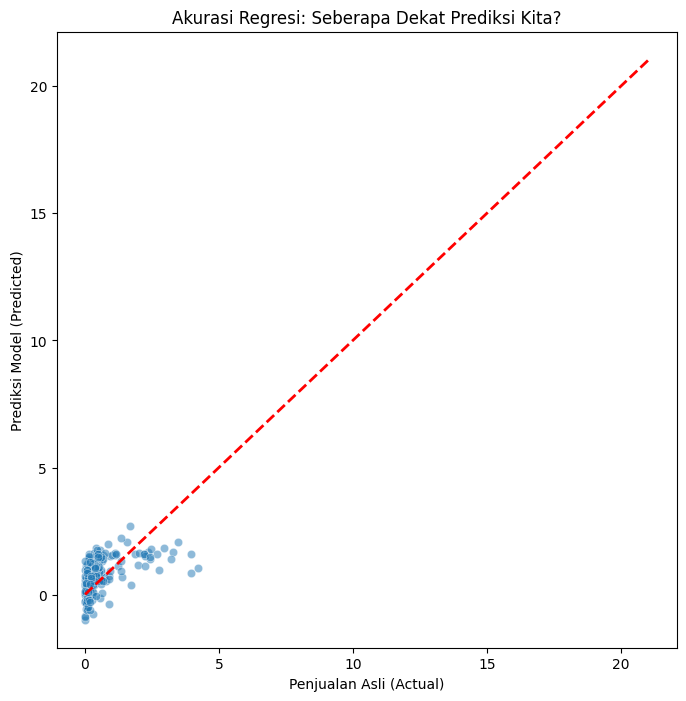

In [13]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Garis ideal
plt.xlabel('Penjualan Asli (Actual)')
plt.ylabel('Prediksi Model (Predicted)')
plt.title('Akurasi Regresi: Seberapa Dekat Prediksi Kita?')
plt.show()

### Save Model

In [15]:
print("\nMenyimpan Model...")
os.makedirs('../backend/app/models', exist_ok=True)

joblib.dump(model, '../backend/app/models/model_regression.pkl')
joblib.dump(feature_names, '../backend/app/models/model_features.pkl') # Penting buat bikin dummy input di backend

print("Model Regresi & Fitur tersimpan.")


Menyimpan Model...
Model Regresi & Fitur tersimpan.
